# 第一步 导入图片数据


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator    #从tensorflow中导入ImageDataGenerator
import numpy as np                                                     #导入numpy并命名np
IMSIZE=128       #定义图片尺寸
sample_size=1000 #定义样本大小

background_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './lesson4/background',
    target_size=(4*IMSIZE, 4*IMSIZE),
    batch_size=6,
    class_mode='categorical')
head_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    ).flow_from_directory(
    "./lesson4/head",
    target_size=(IMSIZE, IMSIZE),
    batch_size=10,
    class_mode='categorical'
)
X0 = np.zeros([sample_size,2*IMSIZE,2*IMSIZE,3])   #无头像图片
Y0 = np.zeros([sample_size,2])                     #无头像分类
X1 = np.zeros([sample_size,2*IMSIZE,2*IMSIZE,3])   #有头像图片
Y1 = np.zeros([sample_size,2])                     #有头像分类


Found 6 images belonging to 2 classes.
Found 10 images belonging to 3 classes.


# 第二步 生成合成数据

(256, 256, 3) (256, 256, 3)


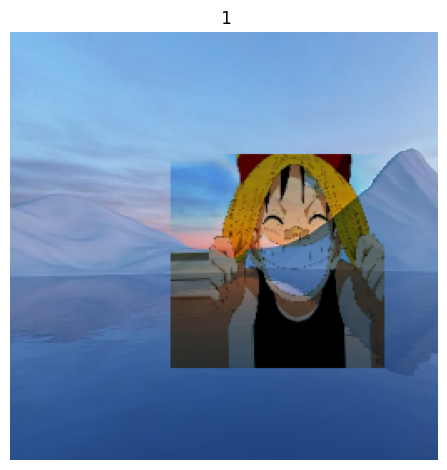

In [174]:
face_size = IMSIZE

for i in range(sample_size):
      xx0=np.random.randint(0,4*IMSIZE-2*face_size);xx1=xx0+2*face_size
      yy0=np.random.randint(0,4*IMSIZE-2*face_size);yy1=yy0+2*face_size
      x0=np.random.randint(0,2*IMSIZE-face_size);x1=x0+face_size
      y0=np.random.randint(0,2*IMSIZE-face_size);y1=y0+face_size
      aa = next(background_generator)
      bb = next(head_generator)
      X0[i,:,:,:] = aa[0][0,xx0:xx1,yy0:yy1,:];Y0[i,0]=1;Y0[i,1]=0    #无头像的哑变量是【10】
      #print(X0[0].shape,bb[0][0].shape)
      X1[i,:,:,:] = aa[0][0,xx0:xx1,yy0:yy1,:];X1[i,x0:x1,y0:y1,:]=X1[i,x0:x1,y0:y1,:]*bb[0][0] ;Y1[i,0]=0;Y1[i,1]=1  #有头像的哑变量是【01】

print(X0[0].shape,X1[0].shape)
from matplotlib import pyplot as plt
plt.imshow(aa[0][0])
plt.imshow(X1[0])
plt.axis('off')
plt.title(f' {1}')
plt.tight_layout()
plt.show()

# 第三步 切割图片

In [175]:
XX = np.vstack((X0,X1));YY = np.vstack((Y0,Y1))
xx0 = int(0.5*face_size);xx1 = xx0+face_size
yy0 = int(0.5*face_size);yy1 = yy0+face_size

XX = XX[:,xx0:xx1,yy0:yy1,:]   #  裁剪所有图片

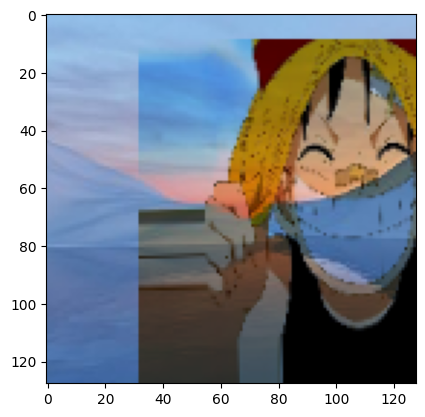

In [176]:
plt.imshow(XX[1000])

# 第四步 随机split数据

In [177]:
from sklearn.model_selection import train_test_split
XX0,XX1,YY0,YY1 = train_test_split(XX,YY,test_size=0.5,random_state=1)

# 第五步 搭建模型

In [178]:
from keras.layers import Dense,Flatten,Input,Activation,Conv2D
from keras.layers import MaxPooling2D,BatchNormalization
from keras import Model

ConLayer = 20
ConNumber = 3
NurNumber = 200
DenNumber = 5
input_size = [IMSIZE,IMSIZE,3]
input_layer = Input(input_size)
x = input_layer
x = BatchNormalization()(x)

for i in range(ConNumber):
    x = Conv2D(ConLayer,[5,5],padding='same',activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)

for i in range(DenNumber):
    x = Dense(NurNumber,activation="relu")(x)

x = Dense(2,activation="softmax")(x)
output_layer = x
model = Model(input_layer, output_layer)
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 20)   │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 20)     │        10,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 20)     │        10,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 200)            │     1,024,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,974 (4.60 MB)

 Trainable params: 1,206,968 (4.60 MB)

 Non-trainable params: 6 (24.00 B)

# 第六步 开始训练

In [182]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model_new.h5', monitor='val_acc', verbose=1, save_best_only=True,mode='max')


model.fit(XX0,YY0,
          validation_data=(XX1,YY1),
          batch_size=1000,
          epochs=100,
          #callbacks=[checkpoint]               #    此处不在更新已经优化后的model
          )

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 3.5711e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 3.5711e-06 - val_accuracy: 0.8710 - val_loss: 0.8353
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 1.0000 - loss: 3.3785e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.3785e-06 - val_accuracy: 0.8640 - val_loss: 0.8891
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 1.0000 - loss: 8.6077e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 8.6077e-06 - val_accuracy: 0.8760 - val_loss: 0.7814
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 1.0000 - loss: 3.8914e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.8914e-06 - val_accuracy: 0.8850 - val_loss: 0.7124
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 1.0000 - loss: 1.5912e-05

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.5912e-05 - val_accuracy: 0.8810 - val_loss: 0.7459
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 1.0000 - loss: 1.8074e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.8074e-06 - val_accuracy: 0.8800 - val_loss: 0.7771
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 1.0000 - loss: 5.3091e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 5.3091e-06 - val_accuracy: 0.8760 - val_loss: 0.8038
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 9.7255e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.7255e-06 - val_accuracy: 0.8760 - val_loss: 0.8101
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 1.0000 - loss: 4.2718e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 4.2718e-06 - val_accuracy: 0.8800 - val_loss: 0.8010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 1.0000 - loss: 1.4857e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4857e-06 - val_accuracy: 0.8850 - val_loss: 0.7870
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 1.0000 - loss: 9.6546e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.6546e-07 - val_accuracy: 0.8880 - val_loss: 0.7729
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 1.0000 - loss: 1.6521e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.6521e-06 - val_accuracy: 0.8880 - val_loss: 0.7574
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 2.1470e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.1470e-06 - val_accuracy: 0.8920 - val_loss: 0.7421
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 1.0000 - loss: 2.9152e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.9152e-06 - val_accuracy: 0.8940 - val_loss: 0.7278
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 1.0000 - loss: 3.3375e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.3375e-06 - val_accuracy: 0.8940 - val_loss: 0.7140
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 1.0000 - loss: 2.9781e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.9781e-06 - val_accuracy: 0.8970 - val_loss: 0.7015
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 1.0000 - loss: 1.7935e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.7935e-06 - val_accuracy: 0.8980 - val_loss: 0.6902
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 1.0000 - loss: 1.1949e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1949e-06 - val_accuracy: 0.9010 - val_loss: 0.6781
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 1.0000 - loss: 6.1285e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 6.1285e-07 - val_accuracy: 0.9030 - val_loss: 0.6661
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 1.0000 - loss: 4.5311e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 4.5311e-07 - val_accuracy: 0.9070 - val_loss: 0.6544
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 1.0000 - loss: 4.5442e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 4.5442e-07 - val_accuracy: 0.9100 - val_loss: 0.6430
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 1.0000 - loss: 5.4418e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 5.4418e-07 - val_accuracy: 0.9110 - val_loss: 0.6319
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 7.9033e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 7.9033e-07 - val_accuracy: 0.9140 - val_loss: 0.6215
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 1.0000 - loss: 1.0937e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0937e-06 - val_accuracy: 0.9150 - val_loss: 0.6122
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 1.0000 - loss: 1.0533e-06

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0533e-06 - val_accuracy: 0.9150 - val_loss: 0.6031
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 1.0000 - loss: 8.0868e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 8.0868e-07 - val_accuracy: 0.9160 - val_loss: 0.5936
Epoch 27/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 1.0000 - loss: 5.0794e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 5.0794e-07 - val_accuracy: 0.9170 - val_loss: 0.5831
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 4.5263e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 4.5263e-07 - val_accuracy: 0.9210 - val_loss: 0.5718
Epoch 29/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 1.0000 - loss: 3.6061e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.6061e-07 - val_accuracy: 0.9230 - val_loss: 0.5603
Epoch 30/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 1.0000 - loss: 3.6084e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.6084e-07 - val_accuracy: 0.9240 - val_loss: 0.5492
Epoch 31/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 1.0000 - loss: 2.8527e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.8527e-07 - val_accuracy: 0.9250 - val_loss: 0.5383
Epoch 32/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 1.0000 - loss: 2.6059e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.6059e-07 - val_accuracy: 0.9270 - val_loss: 0.5273
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 2.8813e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.8813e-07 - val_accuracy: 0.9270 - val_loss: 0.5172
Epoch 34/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 1.0000 - loss: 2.5892e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.5892e-07 - val_accuracy: 0.9280 - val_loss: 0.5077
Epoch 35/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 2.7430e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.7430e-07 - val_accuracy: 0.9300 - val_loss: 0.4987
Epoch 36/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 1.0000 - loss: 2.7478e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.7478e-07 - val_accuracy: 0.9320 - val_loss: 0.4899
Epoch 37/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 1.0000 - loss: 2.9576e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.9576e-07 - val_accuracy: 0.9330 - val_loss: 0.4816
Epoch 38/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 2.9695e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.9695e-07 - val_accuracy: 0.9350 - val_loss: 0.4739
Epoch 39/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 1.0000 - loss: 2.9027e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.9027e-07 - val_accuracy: 0.9360 - val_loss: 0.4670
Epoch 40/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 1.0000 - loss: 2.8145e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.8145e-07 - val_accuracy: 0.9360 - val_loss: 0.4608
Epoch 41/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 1.0000 - loss: 2.7323e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.7323e-07 - val_accuracy: 0.9360 - val_loss: 0.4548
Epoch 42/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 1.0000 - loss: 2.8336e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.8336e-07 - val_accuracy: 0.9370 - val_loss: 0.4487
Epoch 43/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 1.0000 - loss: 2.3866e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.3866e-07 - val_accuracy: 0.9380 - val_loss: 0.4423
Epoch 44/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 1.0000 - loss: 2.1291e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.1291e-07 - val_accuracy: 0.9390 - val_loss: 0.4359
Epoch 45/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 1.0000 - loss: 2.0838e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.0838e-07 - val_accuracy: 0.9410 - val_loss: 0.4297
Epoch 46/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 1.0000 - loss: 1.9908e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.9908e-07 - val_accuracy: 0.9420 - val_loss: 0.4236
Epoch 47/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 1.0000 - loss: 2.3126e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.3126e-07 - val_accuracy: 0.9430 - val_loss: 0.4174
Epoch 48/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 1.7953e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.7953e-07 - val_accuracy: 0.9450 - val_loss: 0.4110
Epoch 49/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 1.0000 - loss: 1.7703e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.7703e-07 - val_accuracy: 0.9450 - val_loss: 0.4048
Epoch 50/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 1.0000 - loss: 1.6749e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.6749e-07 - val_accuracy: 0.9480 - val_loss: 0.3989
Epoch 51/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 1.0000 - loss: 1.7512e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.7512e-07 - val_accuracy: 0.9500 - val_loss: 0.3928
Epoch 52/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 1.0000 - loss: 2.2959e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.2959e-07 - val_accuracy: 0.9510 - val_loss: 0.3853
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 1.0000 - loss: 1.5843e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.5843e-07 - val_accuracy: 0.9530 - val_loss: 0.3776
Epoch 54/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 1.0000 - loss: 1.6367e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.6367e-07 - val_accuracy: 0.9550 - val_loss: 0.3701
Epoch 55/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 1.0000 - loss: 1.5521e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.5521e-07 - val_accuracy: 0.9570 - val_loss: 0.3625
Epoch 56/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 1.0000 - loss: 1.6141e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.6141e-07 - val_accuracy: 0.9580 - val_loss: 0.3549
Epoch 57/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 1.0000 - loss: 1.6046e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.6046e-07 - val_accuracy: 0.9570 - val_loss: 0.3475
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 1.0000 - loss: 1.4985e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4985e-07 - val_accuracy: 0.9580 - val_loss: 0.3405
Epoch 59/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 1.0000 - loss: 1.4889e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4889e-07 - val_accuracy: 0.9590 - val_loss: 0.3335
Epoch 60/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 1.0000 - loss: 1.4269e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4269e-07 - val_accuracy: 0.9590 - val_loss: 0.3268
Epoch 61/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 1.0000 - loss: 1.4174e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4174e-07 - val_accuracy: 0.9590 - val_loss: 0.3202
Epoch 62/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 1.0000 - loss: 1.3685e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.3685e-07 - val_accuracy: 0.9590 - val_loss: 0.3138
Epoch 63/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 1.0000 - loss: 1.3971e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.3971e-07 - val_accuracy: 0.9590 - val_loss: 0.3076
Epoch 64/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 1.0000 - loss: 1.5986e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.5986e-07 - val_accuracy: 0.9590 - val_loss: 0.3013
Epoch 65/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 1.0000 - loss: 1.4377e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4377e-07 - val_accuracy: 0.9600 - val_loss: 0.2949
Epoch 66/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 1.0000 - loss: 1.2875e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.2875e-07 - val_accuracy: 0.9610 - val_loss: 0.2885
Epoch 67/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 1.0000 - loss: 1.4174e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4174e-07 - val_accuracy: 0.9620 - val_loss: 0.2824
Epoch 68/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 1.2541e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.2541e-07 - val_accuracy: 0.9630 - val_loss: 0.2763
Epoch 69/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 1.0000 - loss: 1.2755e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.2755e-07 - val_accuracy: 0.9630 - val_loss: 0.2705
Epoch 70/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 1.0000 - loss: 1.4102e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.4102e-07 - val_accuracy: 0.9630 - val_loss: 0.2652
Epoch 71/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 1.0000 - loss: 1.2255e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.2255e-07 - val_accuracy: 0.9640 - val_loss: 0.2602
Epoch 72/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 1.0000 - loss: 1.1897e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1897e-07 - val_accuracy: 0.9650 - val_loss: 0.2556
Epoch 73/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 1.0000 - loss: 1.2171e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.2171e-07 - val_accuracy: 0.9660 - val_loss: 0.2511
Epoch 74/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 1.0000 - loss: 1.1599e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1599e-07 - val_accuracy: 0.9660 - val_loss: 0.2467
Epoch 75/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 1.0000 - loss: 1.1682e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1682e-07 - val_accuracy: 0.9680 - val_loss: 0.2425
Epoch 76/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 1.0000 - loss: 1.1671e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1671e-07 - val_accuracy: 0.9680 - val_loss: 0.2385
Epoch 77/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 1.0000 - loss: 1.1265e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1265e-07 - val_accuracy: 0.9680 - val_loss: 0.2346
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 1.1337e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1337e-07 - val_accuracy: 0.9680 - val_loss: 0.2309
Epoch 79/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 1.0000 - loss: 1.1063e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1063e-07 - val_accuracy: 0.9680 - val_loss: 0.2272
Epoch 80/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 1.0000 - loss: 1.1086e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1086e-07 - val_accuracy: 0.9680 - val_loss: 0.2237
Epoch 81/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 1.0000 - loss: 1.1981e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1981e-07 - val_accuracy: 0.9680 - val_loss: 0.2202
Epoch 82/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 1.0000 - loss: 1.0657e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0657e-07 - val_accuracy: 0.9680 - val_loss: 0.2170
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 1.0000 - loss: 1.1027e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1027e-07 - val_accuracy: 0.9680 - val_loss: 0.2138
Epoch 84/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 1.0000 - loss: 1.1110e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1110e-07 - val_accuracy: 0.9690 - val_loss: 0.2107
Epoch 85/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 1.0000 - loss: 1.0455e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0455e-07 - val_accuracy: 0.9690 - val_loss: 0.2075
Epoch 86/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 1.0000 - loss: 1.0383e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0383e-07 - val_accuracy: 0.9690 - val_loss: 0.2045
Epoch 87/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 1.0000 - loss: 1.0324e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0324e-07 - val_accuracy: 0.9700 - val_loss: 0.2017
Epoch 88/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 1.0000 - loss: 1.1659e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.1659e-07 - val_accuracy: 0.9700 - val_loss: 0.1988
Epoch 89/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 1.0000 - loss: 1.0180e-07

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0180e-07 - val_accuracy: 0.9700 - val_loss: 0.1958
Epoch 90/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 1.0000 - loss: 9.9778e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.9778e-08 - val_accuracy: 0.9700 - val_loss: 0.1928
Epoch 91/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 1.0000 - loss: 9.9420e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.9420e-08 - val_accuracy: 0.9700 - val_loss: 0.1899
Epoch 92/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 1.0000 - loss: 9.7155e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.7155e-08 - val_accuracy: 0.9710 - val_loss: 0.1870
Epoch 93/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 9.6440e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.6440e-08 - val_accuracy: 0.9700 - val_loss: 0.1843
Epoch 94/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 1.0000 - loss: 9.4175e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.4175e-08 - val_accuracy: 0.9700 - val_loss: 0.1817
Epoch 95/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 1.0000 - loss: 9.5248e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.5248e-08 - val_accuracy: 0.9710 - val_loss: 0.1792
Epoch 96/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 1.0000 - loss: 9.4175e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.4175e-08 - val_accuracy: 0.9720 - val_loss: 0.1768
Epoch 97/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 1.0000 - loss: 9.5248e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.5248e-08 - val_accuracy: 0.9720 - val_loss: 0.1746
Epoch 98/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 9.3818e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.3818e-08 - val_accuracy: 0.9720 - val_loss: 0.1725
Epoch 99/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 1.0000 - loss: 9.5248e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.5248e-08 - val_accuracy: 0.9720 - val_loss: 0.1705
Epoch 100/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 1.0000 - loss: 9.0599e-08

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.0599e-08 - val_accuracy: 0.9720 - val_loss: 0.1686


# 第七步 检查准确度

In [197]:
BigBackground = next(background_generator)[0][0]
bb0 = np.random.randint(0,4*IMSIZE-face_size);bb1 = bb0+face_size
cc0 = np.random.randint(0,4*IMSIZE-face_size);cc1 = cc0+face_size
BigBackground[bb0:bb1,cc0:cc1,:] = BigBackground[bb0:bb1,cc0:cc1,:]*next(head_generator)[0][0]

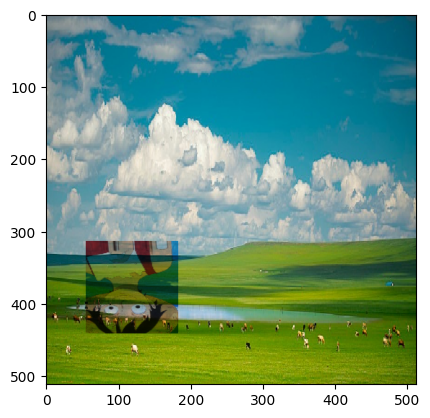

In [198]:
plt.imshow(BigBackground)

In [199]:
nx,ny,nz = BigBackground.shape
nsimu = 10**4
location = np.zeros([nsimu,2])
Z = np.zeros([nsimu,IMSIZE,IMSIZE,3])
for i in range(nsimu):
    x0 = np.random.randint(0,nx-IMSIZE); x1 = x0+IMSIZE
    y0 = np.random.randint(0,ny-IMSIZE); y1 = y0+IMSIZE
    Z[i] = BigBackground[x0:x1,y0:y1,:]
    location[i]=[x0,y0]


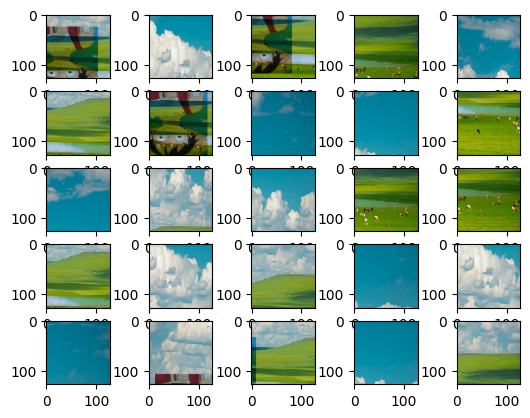

In [200]:
fig,ax = plt.subplots(5,5)
ax = ax.flatten()
for i in range(5*5):
    ax[i].imshow(Z[i])

In [201]:
from tensorflow.keras.models import load_model
PreModel = load_model('model.h5')
prob = PreModel.predict(Z)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


Text(0.5, 1.0, '1.0')

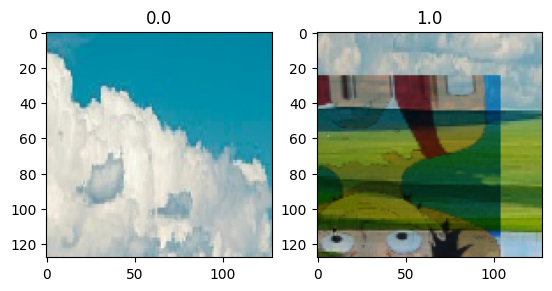

In [207]:
import pandas as pd
id0,id1 = np.argmax(prob,axis = 0)
fig,ax = plt.subplots(1,2)
ax[0].imshow(Z[id0]);ax[0].set_title(np.round(prob[id0,1]))
ax[1].imshow(Z[id1]);ax[1].set_title(np.round(prob[id1,1]))

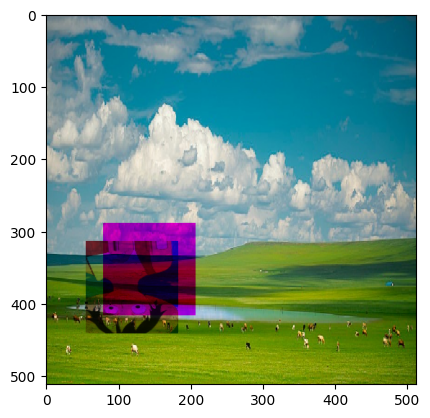

In [209]:
x0,y0 = location[id1]
x0=int(x0);y0=int(y0)
BigBackground[x0:x0+IMSIZE,y0:y0+IMSIZE,1]=0
plt.imshow(BigBackground)